In [605]:
import pandas as pd 
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [606]:
# import the data
df_actual = pd.read_csv('UTMSBA_ACTL.csv')
df_schd = pd.read_csv('UTMSBA_SCHD.csv')
df_fuel = pd.read_csv('UTMSBA_FUELPRICE.csv')

In [607]:
# get the month and year for merging purposes, drop the date
def get_month_year(x):
    month = int(x[5:7])
    year = int(x[:4])
    return month,year

df_actual['month'] = df_actual['Dep_dt'].copy()
df_actual['month'] = df_actual['month'].map(get_month_year)

df_fuel['month'] = df_fuel['Date'].copy()
df_fuel['month'] = df_fuel['month'].map(get_month_year)

df_actual.drop('Dep_dt',axis=1,inplace=True)

# Split and Aggregate the Data by Quantile

In [608]:
# find and order the airports by the number of fights, add log flights as a column
df_count = df_actual['Orig'].value_counts().reset_index()
df_count['log count'] = np.log(df_count['Orig'])

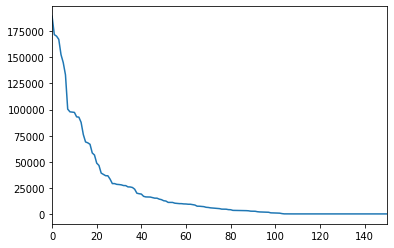

In [609]:
df_count['Orig'].plot()

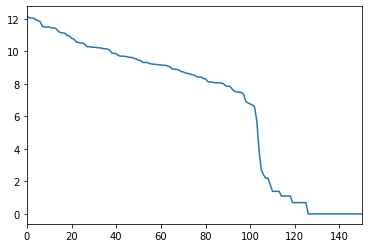

In [610]:
df_count['log count'].plot()

In [611]:
# based on the plots above, split into 3 quantiles
quant1 = df_count[:47]
quant2 = df_count[47:104]
quant3 = df_count[104:]

In [612]:
# split up the data sets
df_quant1 = df_actual[df_actual['Orig'].isin(list(quant1['index']))]
df_quant2 = df_actual[df_actual['Orig'].isin(list(quant2['index']))]
df_quant3 = df_actual[df_actual['Orig'].isin(list(quant3['index']))]

# Make the Data Monthly by Quantile

In [732]:
# define function to one-hot-encode
def one_hot_encode(data):
    
    # one-hot-encode orig
    one_hot = pd.get_dummies(data['Orig'])
    data_ret = data.drop('Orig',axis = 1)
    data_ret = data_ret.join(one_hot.add_suffix('_orig'))
    
    # one-hot-encode dest
    one_hot = pd.get_dummies(data['Dest'])
    data_ret = data_ret.drop('Dest',axis = 1)
    data_ret = data_ret.join(one_hot.add_suffix('_dest'))
    
    # one-hot-encode tail
    one_hot = pd.get_dummies(data['Tail'])
    data_ret = data_ret.drop('Tail',axis = 1)
    data_ret = data_ret.join(one_hot.add_suffix('_tail'))
    
    # one-hot-encode ACFT
    one_hot = pd.get_dummies(data['ACFT'])
    data_ret = data_ret.drop('ACFT',axis = 1)
    data_ret = data_ret.join(one_hot.add_suffix('_acft'))

    return data_ret

In [614]:
# one-hot-encode the quantiles
df_quant1 = one_hot_encode(df_quant1)
df_quant2 = one_hot_encode(df_quant2)
df_quant3 = one_hot_encode(df_quant3)

In [615]:
# create a list of columns for column selection in the following groupby's
list_q1 = []
for i in list(df_quant1.columns):
    if i != 'month':
        list_q1.append(i)
        
list_q2 = []
for i in list(df_quant2.columns):
    if i != 'month':
        list_q2.append(i)
        
list_q3 = []
for i in list(df_quant3.columns):
    if i != 'month':
        list_q3.append(i)

In [616]:
# Groupby month for each quantile
df_quant1 = df_quant1.groupby(['month'])[list_q1].sum().reset_index()
df_quant2 = df_quant2.groupby(['month'])[list_q2].sum().reset_index()
df_quant3 = df_quant3.groupby(['month'])[list_q3].sum().reset_index()

In [617]:
# split up the fuel data sets based on the quantiles
df_fuel1 = df_fuel[df_fuel['Hashed_Station'].isin(list(quant1['index']))][['Hashed_Station','Hashed_Fuel_Price','month']]
df_fuel2 = df_fuel[df_fuel['Hashed_Station'].isin(list(quant2['index']))][['Hashed_Station','Hashed_Fuel_Price','month']]
df_fuel3 = df_fuel[df_fuel['Hashed_Station'].isin(list(quant3['index']))][['Hashed_Station','Hashed_Fuel_Price','month']]

In [618]:
# group the fuel data by month
df_fuel1 = df_fuel1.groupby(['month'])['Hashed_Fuel_Price'].mean()
df_fuel2 = df_fuel2.groupby(['month'])['Hashed_Fuel_Price'].mean()
df_fuel3 = df_fuel3.groupby(['month'])['Hashed_Fuel_Price'].mean()

In [619]:
# merge the fuel and actual data into 1 monthly dataset per quantile
df_quant1 = df_quant1.merge(df_fuel1, on = 'month', how='left')
df_quant2 = df_quant2.merge(df_fuel2, on = 'month', how='left')
df_quant3 = df_quant3.merge(df_fuel3, on = 'month', how='left')

# Regression by Quantile

In [624]:
# define a data pre-processor function
def get_month(x):
    x = list(x)
    month = x[0]
    
    return month

def pre_processor(data, n, drop):
    temp = data.copy()
    if drop == True:
        temp.drop('month',axis=1,inplace=True)
    elif drop == False:
        temp['month'] = temp['month'].map(get_month)
    y = temp['Gross_gal']
    x = temp.drop(columns = ['Gross_gal','Alt_gal','Enroute_gal','Cont_gal'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n)
    
    return x_train, x_test, y_train, y_test

In [ ]:
# create a function which finds the best parameters to use in the model (takes a while to run)
def best_parameters(x_train,y_train):
    param_grid = { 
        'n_estimators': [10, 100, 500],
        'learning_rate':[.1, .2, .3],
        'max_depth' : [2, 3, 4, 5],
        'colsample_bytree' : [.2,.3,.4],
        'alpha' : [1,2,5,10]
    }
    xgb_grid = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid)
    xgb_grid.fit(x_train, y_train)                
    return xgb_grid.best_params_

In [625]:
# create a function which fits, predicts, and calculates the error
def fit_pred(data,params,x_train,x_test,y_train,y_test):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'])
    xg_reg.fit(x_train,y_train)
    pred = xg_reg.predict(x_test)
    
    # calculate rmse
    rmse = np.sqrt(mean_squared_error(y_test, pred))

    # percent error based off of the mean of Gross_gal
    per = rmse/data['Gross_gal'].mean()
    
    return rmse, per

In [626]:
# split the data and find the best parameters for q1
x_train_q1, x_test_q1, y_train_q1, y_test_q1 = pre_processor(df_quant1,.2,True)
params_q1 = best_parameters(x_train_q1,y_train_q1)

In [627]:
# split the data and find the best parameters for q2
x_train_q2, x_test_q2, y_train_q2, y_test_q2 = pre_processor(df_quant2,.2,True)
params_q2 = best_parameters(x_train_q2,y_train_q2)

In [628]:
# split the data and find the best parameters for q3
x_train_q3, x_test_q3, y_train_q3, y_test_q3 = pre_processor(df_quant3,.2,True)
params_q3 = best_parameters(x_train_q3,y_train_q3)

In [629]:
# calculate the RMSE and percent error of q1 regression
rmse_q1, per_q1 = fit_pred(df_quant1, params_q1, x_train_q1, x_test_q1, y_train_q1, y_test_q1)
print('RMSE =',rmse_q1)
print('Percent Error =',per_q1)

RMSE = 4356840.5353827765
Percent Error = 0.027487882150162703


In [630]:
# calculate the RMSE and percent error of q2 regression
rmse_q2, per_q2 = fit_pred(df_quant2, params_q2, x_train_q2, x_test_q2, y_train_q2, y_test_q2)
print('RMSE =',rmse_q2)
print('Percent Error =',per_q2)

RMSE = 1320663.7372361515
Percent Error = 0.0900582642854025


In [632]:
# calculate the RMSE and percent error of q3 regression
rmse_q3, per_q3 = fit_pred(df_quant3, params_q3, x_train_q3, x_test_q3, y_train_q3, y_test_q3)
print('RMSE =',rmse_q3)
print('Percent Error =',per_q3)

RMSE = 2020.9064543958207
Percent Error = 0.7494682926526904


# Simulation of RMSE

In [639]:
# define a function which simulates the building of a model n times
def simulate(data,params,n,m,drop):
    rmse_list = []
    per_list = []
    for i in range(0,n):
        x_train, x_test, y_train, y_test = pre_processor(data, m, drop)
        rmse, per = fit_pred(data, params, x_train, x_test, y_train, y_test)
        rmse_list.append(rmse)
        per_list.append(per)
    rmse_list = pd.Series(rmse_list)
    per_list = pd.Series(per_list)
    return rmse_list,per_list

# define a function which plots the errors
def plot_func(rmse,per,quantile):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    fig.suptitle('Variation in RMSE in {} Simulation'.format(quantile))

    ax1.hist(rmse, bins=50)
    ax1.set_title('{} RMSE'.format(quantile))
    ax1.set(xlabel='Error', ylabel='Count')

    ax2.hist(per,bins=50)
    ax2.set_title('{} RMSE as Percent Error of Mean'.format(quantile))
    ax2.set(xlabel='Percent Error', ylabel='Count')
    
    plt.show()

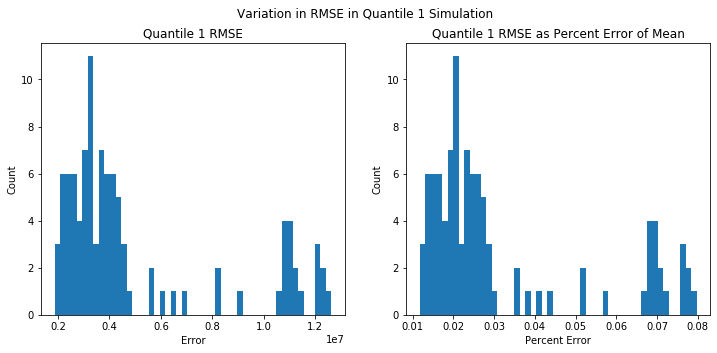

In [634]:
# simulate quantile 1 and plot
rmse_q1, per_q1 = simulate(df_quant1,params_q1,100,.2,True)
plot_func(rmse_q1,per_q1,'Quantile 1')

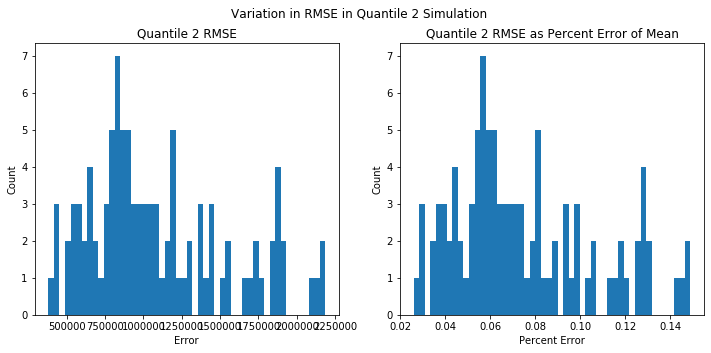

In [635]:
# simulate quantile 2 and plot
rmse_q2, per_q2 = simulate(df_quant2,params_q2,100,.2,True)
plot_func(rmse_q2,per_q2,'Quantile 2')

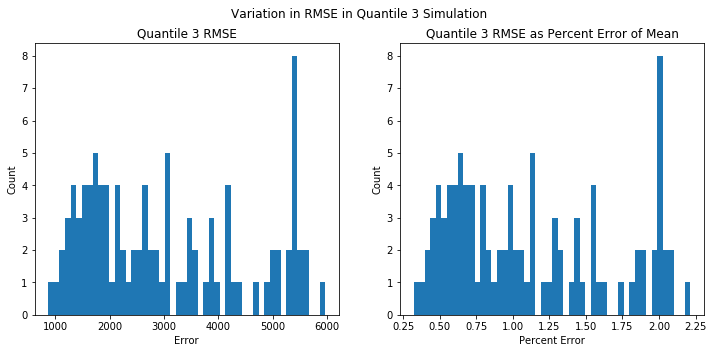

In [640]:
# simulate quantile 3 and plot
rmse_q3, per_q3 = simulate(df_quant3,params_q1,100,.2,True)
plot_func(rmse_q3,per_q3,'Quantile 3')

# Simulate Errors

##### To simulate the errors, we are essentially recreating the XGBoost model n times (you provide n), and then calculating the individual errors and plotting them. This is just to see the variablility in the individual errors.

In [641]:
def error_pred(data,params,x_train,x_test,y_train,y_test):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'])
    
    xg_reg.fit(x_train,y_train)

    pred = xg_reg.predict(x_test)
    return pred

In [767]:
# define functions which return the requisite errors and plot them
def errors(data,params,n,m,drop):
    error_list = []
    error_per_list = []
    for i in range(0,n):
        x_train, x_test, y_train, y_test = pre_processor(data, m, drop)
        y_test = y_test.reset_index().drop('index',axis=1)
        pred = pd.Series(error_pred(data, params, x_train, x_test, y_train, y_test))
        err = y_test['Gross_gal']-pred
        err_per = err/y_test['Gross_gal']
        for x in err:
            error_list.append(x)
        for y in err_per:
            error_per_list.append(y)
    return error_list,error_per_list

def plot_errors(error_list,error_per_list,quantile):
    temp = []
    for x in error_per_list:
        if (x != -np.inf) and (x!=np.inf):
            temp.append(x)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    fig.suptitle('Errors in {} Simulation'.format(quantile))

    ax1.hist(error_list, bins=50)
    ax1.set_title('{} Errors'.format(quantile))
    ax1.set(xlabel='Error', ylabel='Count')

    ax2.hist(temp,bins=50)
    ax2.set_title('{} Percent Errors'.format(quantile))
    ax2.set(xlabel='Percent Error', ylabel='Count')
    
    plt.show()

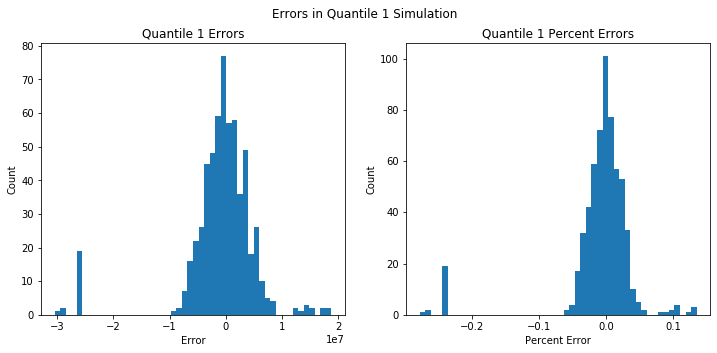

In [643]:
# simulate and plot the errors of q1
q1_err_sim,q1_err_per_sim = errors(df_quant1,params_q1,100,.2,True)
plot_errors(q1_err_sim,q1_err_per_sim,'Quantile 1')

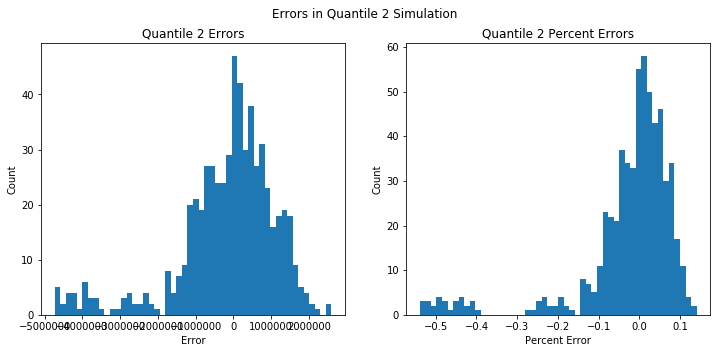

In [644]:
# simulate and plot the errors of q2
q2_err_sim,q2_err_per_sim = errors(df_quant2,params_q2,100,.2,True)
plot_errors(q2_err_sim,q2_err_per_sim,'Quantile 2')

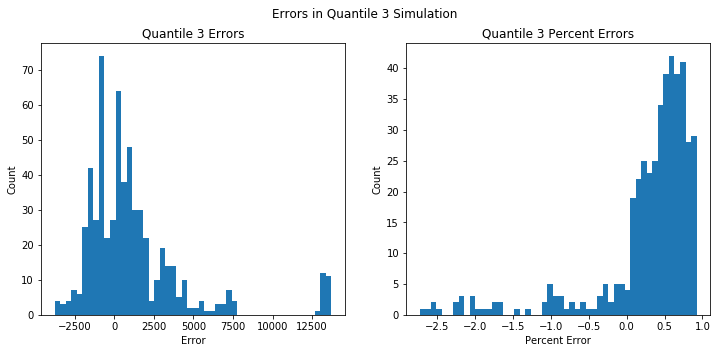

In [687]:
# simulate and plot the errors of q3
q3_err_sim,q3_err_per_sim = errors(df_quant3,params_q3,100,.2,True)
plot_errors(q3_err_sim,q3_err_per_sim,'Quantile 3')

# Regresson Based on 5 Quantiles

### Split Data

In [733]:
# based on the plots above, split into 5 quantiles
quant1_5 = df_count[:32]
quant2_5 = df_count[32:61]
quant3_5 = df_count[61:91]
quant4_5 = df_count[91:121]
quant5_5 = df_count[121:]

In [734]:
# split up the data sets
df_quant1_5 = df_actual[df_actual['Orig'].isin(list(quant1_5['index']))]
df_quant2_5 = df_actual[df_actual['Orig'].isin(list(quant2_5['index']))]
df_quant3_5 = df_actual[df_actual['Orig'].isin(list(quant3_5['index']))]
df_quant4_5 = df_actual[df_actual['Orig'].isin(list(quant4_5['index']))]
df_quant5_5 = df_actual[df_actual['Orig'].isin(list(quant5_5['index']))]

In [735]:
# one-hot-encode the quantiles
df_quant1_5 = one_hot_encode(df_quant1_5)
df_quant2_5 = one_hot_encode(df_quant2_5)
df_quant3_5 = one_hot_encode(df_quant3_5)
df_quant4_5 = one_hot_encode(df_quant4_5)
df_quant5_5 = one_hot_encode(df_quant5_5)

In [751]:
# create a list of columns for column selection in the following groupby's
list_q1_5 = []
for i in list(df_quant1_5.columns):
    if i != 'month':
        list_q1_5.append(i)
        
list_q2_5 = []
for i in list(df_quant2_5.columns):
    if i != 'month':
        list_q2_5.append(i)
        
list_q3_5 = []
for i in list(df_quant3_5.columns):
    if i != 'month':
        list_q3_5.append(i)
        
list_q4_5 = []
for i in list(df_quant4_5.columns):
    if i != 'month':
        list_q4_5.append(i)
        
list_q5_5 = []
for i in list(df_quant5_5.columns):
    if i != 'month':
        list_q5_5.append(i)

In [753]:
# create a groupby for each quantile
df_quant1_5 = df_quant1_5.groupby(['month'])[list_q1_5].sum().reset_index()
df_quant2_5 = df_quant2_5.groupby(['month'])[list_q2_5].sum().reset_index()
df_quant3_5 = df_quant3_5.groupby(['month'])[list_q3_5].sum().reset_index()
df_quant4_5 = df_quant4_5.groupby(['month'])[list_q4_5].sum().reset_index()
df_quant5_5 = df_quant5_5.groupby(['month'])[list_q5_5].sum().reset_index()

In [754]:
# split up the fuel data sets based on the quantiles
df_fuel1_5 = df_fuel[df_fuel['Hashed_Station'].isin(list(quant1_5['index']))][['Hashed_Station','Hashed_Fuel_Price','month']]
df_fuel2_5 = df_fuel[df_fuel['Hashed_Station'].isin(list(quant2_5['index']))][['Hashed_Station','Hashed_Fuel_Price','month']]
df_fuel3_5 = df_fuel[df_fuel['Hashed_Station'].isin(list(quant3_5['index']))][['Hashed_Station','Hashed_Fuel_Price','month']]
df_fuel4_5 = df_fuel[df_fuel['Hashed_Station'].isin(list(quant4_5['index']))][['Hashed_Station','Hashed_Fuel_Price','month']]
df_fuel5_5 = df_fuel[df_fuel['Hashed_Station'].isin(list(quant5_5['index']))][['Hashed_Station','Hashed_Fuel_Price','month']]

In [755]:
# group the fuel data by month
df_fuel1_5 = df_fuel1_5.groupby(['month'])['Hashed_Fuel_Price'].mean()
df_fuel2_5 = df_fuel2_5.groupby(['month'])['Hashed_Fuel_Price'].mean()
df_fuel3_5 = df_fuel3_5.groupby(['month'])['Hashed_Fuel_Price'].mean()
df_fuel4_5 = df_fuel4_5.groupby(['month'])['Hashed_Fuel_Price'].mean()
df_fuel5_5 = df_fuel5_5.groupby(['month'])['Hashed_Fuel_Price'].mean()

In [756]:
# merge the fuel and actual data into 1 monthly dataset per quantile
df_quant1_5 = df_quant1_5.merge(df_fuel1_5, on = 'month', how='left')
df_quant2_5 = df_quant2_5.merge(df_fuel2_5, on = 'month', how='left')
df_quant3_5 = df_quant3_5.merge(df_fuel3_5, on = 'month', how='left')
df_quant4_5 = df_quant4_5.merge(df_fuel4_5, on = 'month', how='left')
df_quant5_5 = df_quant5_5.merge(df_fuel5_5, on = 'month', how='left')

### Fit Model

In [758]:
# split the data and find the best parameters for q1
x_train_q1_5, x_test_q1_5, y_train_q1_5, y_test_q1_5 = pre_processor(df_quant1_5,.2,True)
params_q1_5 = best_parameters(x_train_q1_5,y_train_q1_5)

In [759]:
# split the data and find the best parameters for q2
x_train_q2_5, x_test_q2_5, y_train_q2_5, y_test_q2_5 = pre_processor(df_quant2_5,.2,True)
params_q2_5 = best_parameters(x_train_q2_5,y_train_q2_5)

In [705]:
# split the data and find the best parameters for q3
x_train_q3_5, x_test_q3_5, y_train_q3_5, y_test_q3_5 = pre_processor(df_quant3_5,.2,True)
params_q3_5 = best_parameters(x_train_q3_5,y_train_q3_5)

ValueError: DataFrame for label cannot have multiple columns

In [ ]:
# split the data and find the best parameters for q4
x_train_q4_5, x_test_q4_5, y_train_q4_5, y_test_q4_5 = pre_processor(df_quant4_5,.2,True)
params_q4_5 = best_parameters(x_train_q4_5,y_train_q4_5)

In [ ]:
# split the data and find the best parameters for q5
x_train_q5_5, x_test_q5_5, y_train_q5_5, y_test_q5_5 = pre_processor(df_quant5_5,.2,True)
params_q5_5 = best_parameters(x_train_q5_5,y_train_q5_5)

In [760]:
# calculate the RMSE and percent error of q1 regression
rmse_q1_5, per_q1_5 = fit_pred(df_quant1_5, params_q1_5, x_train_q1_5, x_test_q1_5, y_train_q1_5, y_test_q1_5)
print('RMSE =',rmse_q1_5)
print('Percent Error =',per_q1_5)

RMSE = 9277643.067374326
Percent Error = 0.06540581818973189


In [761]:
# calculate the RMSE and percent error of q2 regression
rmse_q2_5, per_q2_5 = fit_pred(df_quant2_5, params_q2_5, x_train_q2_5, x_test_q2_5, y_train_q2_5, y_test_q2_5)
print('RMSE =',rmse_q2_5)
print('Percent Error =',per_q2_5)

RMSE = 3772319.197409837
Percent Error = 0.15465197408412715


In [ ]:
# calculate the RMSE and percent error of q3 regression
rmse_q3_5, per_q3_5 = fit_pred(df_quant3_5, params_q3_5, x_train_q3_5, x_test_q3_5, y_train_q3_5, y_test_q3_5)
print('RMSE =',rmse_q3_5)
print('Percent Error =',per_q3_5)

In [ ]:
# calculate the RMSE and percent error of q4 regression
rmse_q4_5, per_q4_5 = fit_pred(df_quant4_5, params_q4_5, x_train_q4_5, x_test_q4_5, y_train_q4_5, y_test_q4_5)
print('RMSE =',rmse_q4_5)
print('Percent Error =',per_q4_5)

In [ ]:
# calculate the RMSE and percent error of q5 regression
rmse_q5_5, per_q5_5 = fit_pred(df_quant5_5, params_q5_5, x_train_q5_5, x_test_q5_5, y_train_q5_5, y_test_q5_5)
print('RMSE =',rmse_q5_5)
print('Percent Error =',per_q5_5)

### Simulation of RMSE

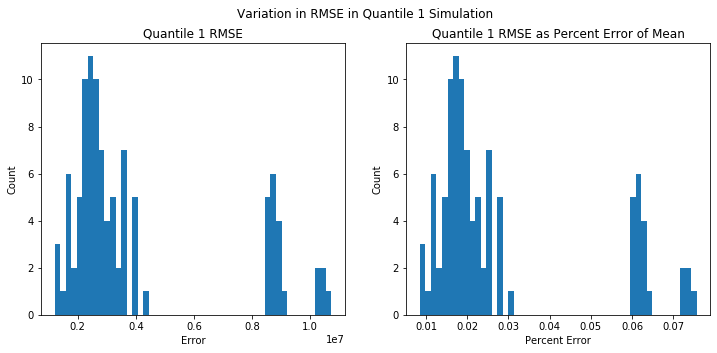

In [766]:
# simulate quantile 1 RMSE and plot
rmse_q1_5, per_q1_5 = simulate(df_quant1_5,params_q1_5,100,.2,True)
plot_func(rmse_q1_5,per_q1_5,'Quantile 1')

In [ ]:
# simulate quantile 2 RMSE and plot
rmse_q2_5, per_q2_5 = simulate(df_quant2_5,params_q2_5,100,.2,True)
plot_func(rmse_q2_5,per_q2_5,'Quantile 2')

In [ ]:
# simulate quantile 3 RMSE and plot
rmse_q3_5, per_q3_5 = simulate(df_quant3_5,params_q3_5,100,.2,True)
plot_func(rmse_q3_5,per_q3_5,'Quantile 3')

In [ ]:
# simulate quantile 4 RMSE and plot
rmse_q4_5, per_q4_5 = simulate(df_quant4_5,params_q4_5,100,.2,True)
plot_func(rmse_q4_5,per_q4_5,'Quantile 4')

In [ ]:
# simulate quantile 5 RMSE and plot
rmse_q5_5, per_q5_5 = simulate(df_quant5_5,params_q5_5,100,.2,True)
plot_func(rmse_q5_5,per_q5_5,'Quantile 5')

### Simulate Errors

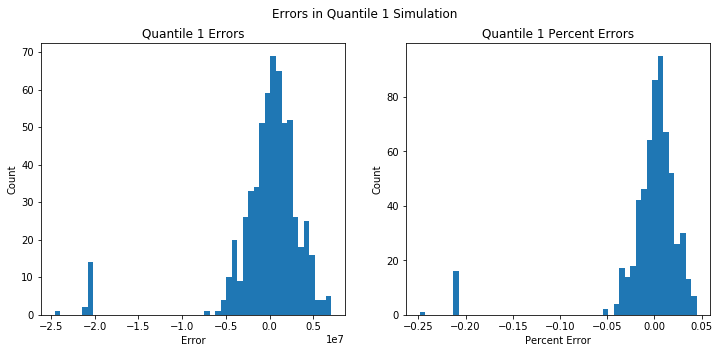

In [768]:
# simulate and plot the errors of q1
q1_err_sim_5,q1_err_per_sim_5 = errors(df_quant1_5,params_q1_5,100,.2,True)
plot_errors(q1_err_sim_5,q1_err_per_sim_5,'Quantile 1')

In [ ]:
# simulate and plot the errors of q2
q2_err_sim_5,q2_err_per_sim_5 = errors(df_quant2_5,params_q2_5,100,.2,True)
plot_errors(q2_err_sim_5,q2_err_per_sim_5,'Quantile 2')

In [ ]:
# simulate and plot the errors of q3
q3_err_sim_5,q3_err_per_sim_5 = errors(df_quant3_5,params_q3_5,100,.2,True)
plot_errors(q3_err_sim_5,q3_err_per_sim_5,'Quantile 3')

In [ ]:
# simulate and plot the errors of q4
q4_err_sim_5,q4_err_per_sim_5 = errors(df_quant4_5,params_q4_5,100,.2,True)
plot_errors(q4_err_sim_5,q4_err_per_sim_5,'Quantile 4')

In [ ]:
# simulate and plot the errors of q5
q5_err_sim_5,q5_err_per_sim_5 = errors(df_quant5_5,params_q5_5,100,.2,True)
plot_errors(q5_err_sim_5,q5_err_per_sim_5,'Quantile 5')